# Disparity-Based Collision Avoidance System

### Deep Learning Project

Skoltech, Spring 2016

* _Anastasia Makarova_
* _Mikhail Usvyatsov_
* _Mikhail Karasikov_
* _Daniil Merkulov_


# Introduction

The goal of our project is to predict the distance to the nearest object on the road from a single image. Neural Networks are widely used in Advanced Driver Assistance Systems (ADAS) and this problem has direct application in Camera-Based Forward Collision Alert System. 

Ordinary, disparity map is built based on stereo pair and then camera parameters are neccessary for depth map building. 

![](images/disparity_scheme.png)

We use semantic annotated data CityScapes and all intristic parameters are known, so the goal was to predict the robust maximum for disparity map, corresponded o the closest object on the road.

As long as we are interested only in objects on the way of the car, we work not only with the entire image, but also with its Region of Interest (RoI).

# Related work

There are several works related to the whole depth map prediction, based on Deep Learning. In 
$\textit{'Depth Map Prediction from a Single Image using a Multi-Scale Deep Network', 2015}$ 
authors consider two steps (coarse-scale and fine-scale) NN Structure. The task of the coarse-scale network is to predict the overall depth map structure using a global view of the scene. After taking a global perspective, local refinements are made by fine-scale network. 

![](images/network_structure.png)

The highly impressive result motivated us to use deep learning approaches for our task.

# Problem setting

The mathematical formulation of problem we deal with is the following.

$X$ --- RGB pictures

$Y$ --- labels

$X^{n}=\left\{(x_1,y_1), \dots, (x_n,y_n)\right\}$ --- training set, where $y_i$ is the maximum disparity for the picture $x_i$.

Find the algorithm $a:\; X\to Y$, which generalizes the target function.

If we replace $y_i$ with the label of bin where $y_i$ occurs we will get formulation of classification problem.

Classification statement has several advantages over regression:

* Classification is easy to train than regression,

* We can easily predict probability for each class (far, close, very far, very close, etc.).

So, further we consider the problem with $2$ or $4$ classes.

# Training set preparation

Typical cityscapes data looks as follows.

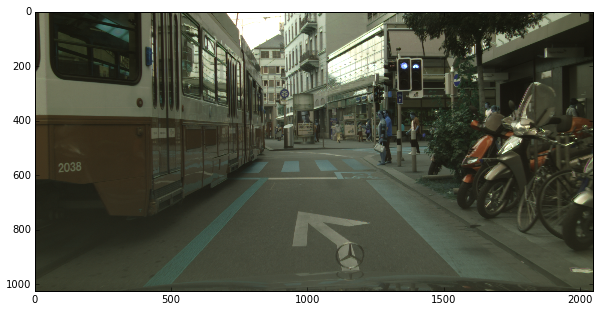

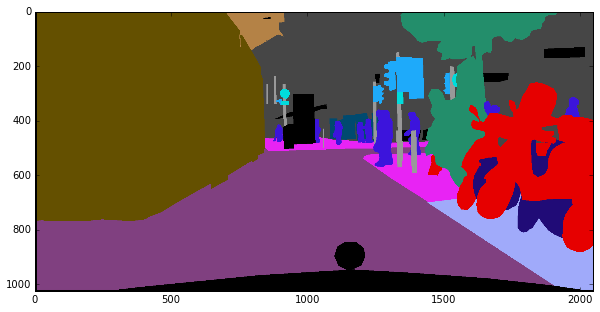

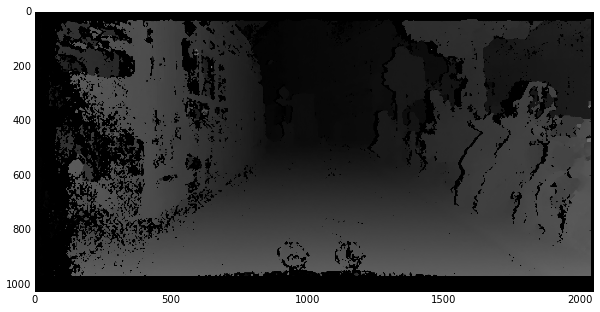

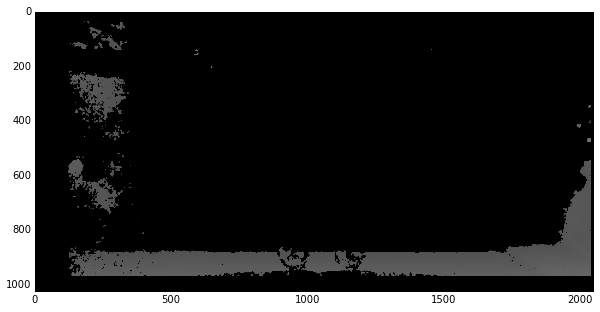

In [8]:
# good example nmb_image = 41, 12
i = np.random.randint(0, len(disp_imgs_paths))

disp = cv2.imread(disp_imgs_paths[i])
img = cv2.imread(imgs_paths[i])
img_path = imgs_paths[i]
anno_img = cv2.imread(anno_imgs_paths[i])

Plot(img)
Plot(anno_img)

''' All disparity'''
Plot(disp)

''' Disparity in percentile '''
disp_perc = disp.copy()
disp_perc[disp < np.percentile(disp, 90)] = 0
Plot(disp_perc)

One can see that maximum disparity or any its percentile is meaningless for training set construction and physically trivial.

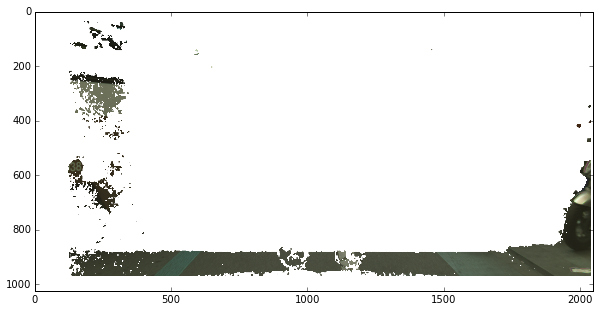

In [10]:
img_perc = img.copy()
img_perc[disp < np.percentile(disp, 90)] = 255
Plot(img_perc)

So, first, the road obviously has to be removed and second, we extract target labels just for region of interest.

## RoI selection

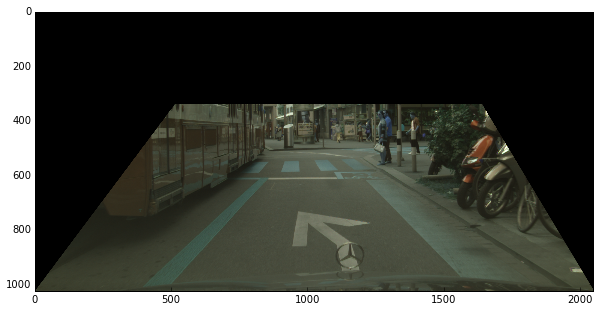

In [11]:
Plot(CropRoI(cv2.imread(img_path, -1)))

## Exluding Road

We remove the road and car logo with the hood from the picture using fine segmentation provided by cityscapes team.

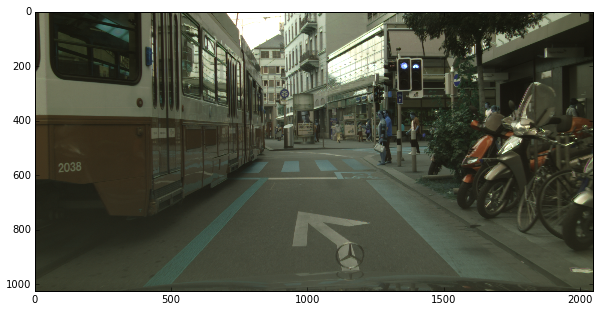

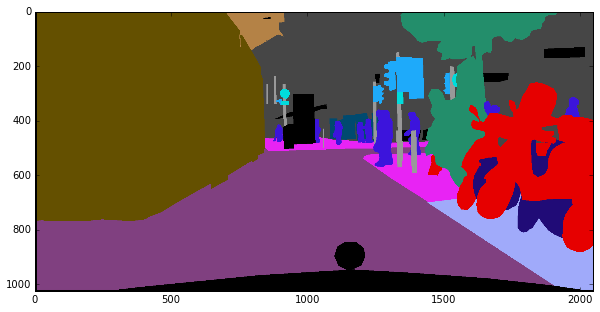

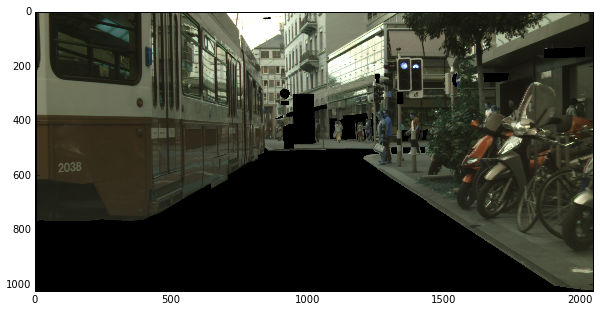

In [12]:
Plot(img)
Plot(anno_img)
masked_img = ExcludeRoadDisp(img, anno_img, [(128, 64, 128), (0, 0, 0)])
Plot(masked_img)

As a result, we got disparity distribution that makes sence and let the problem setting physically meaningful.

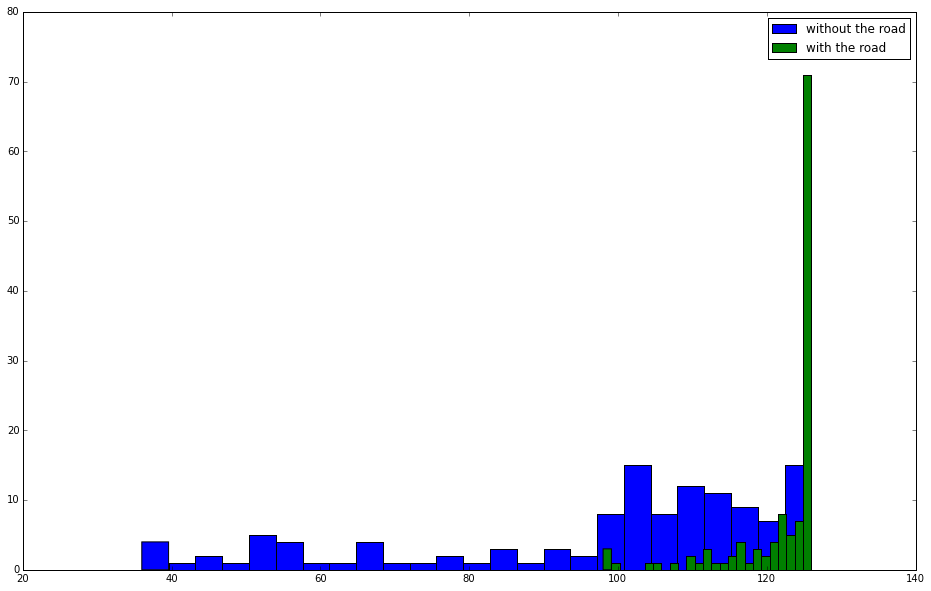

In [18]:
plt.figure(figsize=(16, 10))
plt.hist(max_disps_excl, bins=25, label='without the road')
plt.hist(max_disps, bins=25, label='with the road')
plt.legend(loc='best')

# Features as CNN output

When solving classification problem for pictures it's important to choose suitable feature space $\mathscr{F}$.

As soon as we determined feature space $\mathscr{F}$ and transformation $f:\;X\to\mathscr{F}$, the problem we solve is simplified:
find the algorithm $a:\; f(x)\mapsto y$, which generalizes the target function.

Advances in deep learning provide methods to solve the initial problem straightway, but we couldn't train the CNN due to lack of video card memory on our instance.

So, we decided to use spread pre-trained CNN output as that feature transform $f$.

We used VGG19 with reshaped input layer.
Next we deleted everything after the convolutional layer and used that as features for the next processing.
The structure of VGG19 that we used depictured further. ![](images/1.png)
The result is a tensor of shape [512, 4, 9] raveled to the vector of length $18432$.

# Classification

We applied different methods to solve classification problem.

(array([  16.,   49.,   88.,  163.,  109.,  125.,  120.,  113.,  127.,
         106.,  132.,  134.,  115.,  195.,  295.,  368.,  252.,  131.,
         125.,  212.]),
 array([  14. ,   19.6,   25.2,   30.8,   36.4,   42. ,   47.6,   53.2,
          58.8,   64.4,   70. ,   75.6,   81.2,   86.8,   92.4,   98. ,
         103.6,  109.2,  114.8,  120.4,  126. ]),
 <a list of 20 Patch objects>)

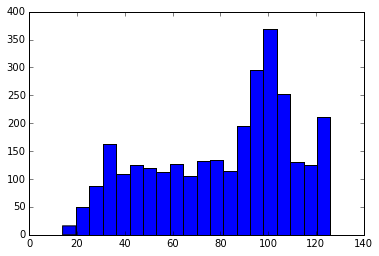

In [5]:
plt.hist(y_train, bins=20)

In [6]:
len(y_train), y_train

(2975, array([86, 93, 43, ..., 39, 97, 95], dtype=uint8))

In [129]:
bins = [np.percentile(y_train, 0),
        np.percentile(y_train, 25),
        np.percentile(y_train, 50),
        np.percentile(y_train, 75),
        np.percentile(y_train, 100) + 1]

In [130]:
bins

[14.0, 57.0, 89.0, 103.0, 127.0]

In [131]:
binary_bins = [np.percentile(y_train, 0),
               np.percentile(y_train, 50),
               np.percentile(y_train, 100) + 1]

In [132]:
binary_bins

[14.0, 89.0, 127.0]

In [138]:
y_train_binary = np.digitize(y_train, binary_bins) - 1
y_val_binary = np.digitize(y_val, binary_bins) - 1
y_test_binary = np.digitize(y_test, binary_bins) - 1

In [139]:
y_train = np.digitize(y_train, bins) - 1
y_val = np.digitize(y_val, bins) - 1
y_test = np.digitize(y_test, bins) - 1

(array([ 739.,    0.,    0.,  715.,    0.,    0.,  721.,    0.,    0.,  800.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

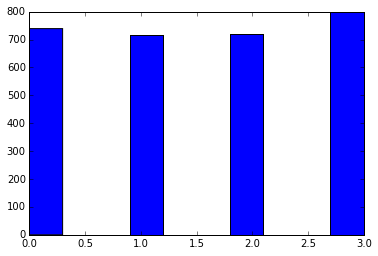

In [140]:
plt.hist(y_train)

(array([ 1454.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  1521.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

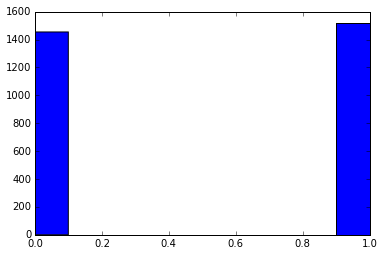

In [141]:
plt.hist(y_train_binary)

# Binary classification

In [142]:
clf = LogisticRegression(C=0.01, penalty='l1')
clf.fit(f1_train, y_train_binary).score(f1_val, y_val_binary)

0.878

# Without the road

In [28]:
clf = LogisticRegression(C=0.01, penalty='l1')
clf.fit(f1_train, y_train).score(f1_val, y_val)

0.68000000000000005

In [14]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer().fit(f1_train)
f1_train_normalized = normalizer.transform(f1_train)
f1_val_normalized = normalizer.transform(f1_val)

In [66]:
from sklearn.svm import LinearSVC

clf = LinearSVC(C=1, penalty='l2', loss='squared_hinge', dual=True, multi_class='crammer_singer')
clf.fit(f1_train_normalized, y_train).score(f1_val_normalized, y_val)

0.67000000000000004

In [55]:
clf = LogisticRegression(C=8, penalty='l1')
clf.fit(f1_train_normalized, y_train).score(f1_val_normalized, y_val)

0.67000000000000004

In [60]:
from sklearn.svm import SVC

clf = SVC(C=1, kernel='rbf', gamma=1)
clf.fit(f1_train_normalized, y_train).score(f1_val_normalized, y_val)

0.66800000000000004

In [61]:
from sklearn.svm import SVC

clf = SVC(C=1, kernel='poly', gamma=1, degree=2)
clf.fit(f1_train_normalized, y_train).score(f1_val_normalized, y_val)

0.67400000000000004

In [46]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1000).fit(f1_train_normalized)

f1_train_pca = pca.transform(f1_train_normalized)
f1_val_pca = pca.transform(f1_val_normalized)

In [45]:
from sklearn.ensemble import GradientBoostingClassifier

GradientBoostingClassifier(n_estimators=200).fit(f1_train_pca, y_train).score(f1_val_pca, y_val)

0.59799999999999998

In [76]:
from stacking import Stacking

basic_wildfowl = Stacking(base_estimators=[
        (LogisticRegression(C=0.01, penalty='l1').fit,
         lambda clf, X: clf.predict(X)),
        (lambda X, y: LinearSVC(C=1, penalty='l2', loss='squared_hinge',
                                dual=True, multi_class='crammer_singer').fit(normalizer.transform(X), y),
         lambda clf, X: clf.predict(normalizer.transform(X))),
        (lambda X, y: LogisticRegression(C=8, penalty='l1').fit(normalizer.transform(X), y),
         lambda clf, X: clf.predict(normalizer.transform(X))),
        (lambda X, y: SVC(C=1, kernel='rbf', gamma=1).fit(normalizer.transform(X), y),
         lambda clf, X: clf.predict(normalizer.transform(X))),
        (lambda X, y: SVC(C=1, kernel='poly', gamma=1, degree=2).fit(normalizer.transform(X), y),
         lambda clf, X: clf.predict(normalizer.transform(X)))],
                    n_folds=5, extend_meta=False)
basic_wildfowl.fit(np.array(f1_train), y_train)

/usr/lib64/python2.7/site-packages/sklearn/cross_validation.py:69: DeprecationWarning: The indices parameter is deprecated and will be removed (assumed True) in 0.17
  stacklevel=1)


Stacking(base_estimators=[(<bound method LogisticRegression.fit of LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)>, <f...on <lambda> at 0x1d848848>), (<function <lambda> at 0x1d848758>, <function <lambda> at 0x1d8488c0>)],
     extend_meta=False, meta_fitter=None, n_folds=5)

In [77]:
basic_wildfowl.fit_meta(SVC(C=5, kernel='poly', degree=2, gamma=1.).fit).score(np.array(f1_val), y_val)

0.68999999999999995

In [80]:
basic_wildfowl.fit_meta(SVC(C=1, kernel='poly', degree=2, gamma=1.).fit).score(np.array(f1_val), y_val)

0.68999999999999995

In [81]:
basic_wildfowl.fit_meta(SVC(C=10, kernel='poly', degree=2, gamma=1.).fit).score(np.array(f1_val), y_val)

0.68999999999999995

In [82]:
basic_wildfowl.fit_meta(SVC(C=1, kernel='rbf', gamma=1.).fit).score(np.array(f1_val), y_val)

0.69799999999999995

In [100]:
basic_wildfowl.fit_meta(SVC(C=1, kernel='rbf', gamma=0.5).fit).score(np.array(f1_val), y_val)

0.70399999999999996

In [109]:
basic_wildfowl.fit_meta(SVC(C=1, kernel='rbf', gamma=0.3).fit).score(np.array(f1_val), y_val)

0.70199999999999996

In [143]:
basic_wildfowl.fit_meta(SVC(C=1, kernel='rbf', gamma=0.2).fit).score(np.array(f1_val), y_val)

0.70599999999999996

In [105]:
basic_wildfowl.fit_meta(SVC(C=1, kernel='rbf', gamma=0.1).fit).score(np.array(f1_val), y_val)

0.70399999999999996

In [83]:
basic_wildfowl.fit_meta(SVC(C=5, kernel='rbf', gamma=1.).fit).score(np.array(f1_val), y_val)

0.69599999999999995

In [84]:
basic_wildfowl.fit_meta(SVC(C=0.5, kernel='rbf', gamma=1.).fit).score(np.array(f1_val), y_val)

0.69399999999999995

In [85]:
basic_wildfowl.fit_meta(LogisticRegression(C=1, penalty='l1').fit).score(np.array(f1_val), y_val)

0.67000000000000004

In [89]:
basic_wildfowl.fit_meta(LogisticRegression(C=10, penalty='l2').fit).score(np.array(f1_val), y_val)

0.67000000000000004

In [92]:
basic_wildfowl.fit_meta(RandomForestClassifier(n_estimators=100).fit).score(np.array(f1_val), y_val)

0.69599999999999995

In [94]:
basic_wildfowl.fit_meta(RandomForestClassifier(n_estimators=50, max_depth=10).fit).score(np.array(f1_val), y_val)

0.68999999999999995

In [95]:
basic_wildfowl.fit_meta(RandomForestClassifier(n_estimators=50, max_depth=20).fit).score(np.array(f1_val), y_val)

0.69599999999999995

In [78]:
basic_wildfowl.fit_meta(GradientBoostingClassifier(n_estimators=200).fit).score(np.array(f1_val), y_val)

0.69399999999999995

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [101]:
basic_wildfowl.fit_meta(AdaBoostClassifier(n_estimators=30).fit).score(np.array(f1_val), y_val)

0.67000000000000004

In [96]:
basic_wildfowl.fit_meta(AdaBoostClassifier(n_estimators=50).fit).score(np.array(f1_val), y_val)

0.68799999999999994

In [97]:
basic_wildfowl.fit_meta(AdaBoostClassifier(n_estimators=100).fit).score(np.array(f1_val), y_val)

0.68000000000000005

In [79]:
basic_wildfowl.score(np.array(f1_train), y_train)

0.88369747899159667

In [144]:
from stacking import Stacking

binary_wildfowl = Stacking(base_estimators=[
        (LogisticRegression(C=0.01, penalty='l1').fit,
         lambda clf, X: clf.predict(X)),
        (lambda X, y: LinearSVC(C=1, penalty='l2', loss='squared_hinge',
                                dual=True, multi_class='crammer_singer').fit(normalizer.transform(X), y),
         lambda clf, X: clf.predict(normalizer.transform(X))),
        (lambda X, y: LogisticRegression(C=8, penalty='l1').fit(normalizer.transform(X), y),
         lambda clf, X: clf.predict(normalizer.transform(X))),
        (lambda X, y: SVC(C=1, kernel='rbf', gamma=1).fit(normalizer.transform(X), y),
         lambda clf, X: clf.predict(normalizer.transform(X))),
        (lambda X, y: SVC(C=1, kernel='poly', gamma=1, degree=2).fit(normalizer.transform(X), y),
         lambda clf, X: clf.predict(normalizer.transform(X)))],
                    n_folds=5, extend_meta=False)
binary_wildfowl.fit(np.array(f1_train), y_train_binary)

/usr/lib64/python2.7/site-packages/sklearn/cross_validation.py:69: DeprecationWarning: The indices parameter is deprecated and will be removed (assumed True) in 0.17
  stacklevel=1)


Stacking(base_estimators=[(<bound method LogisticRegression.fit of LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)>, <f...on <lambda> at 0x3a2548c0>), (<function <lambda> at 0x2ae631b8>, <function <lambda> at 0x2ae635f0>)],
     extend_meta=False, meta_fitter=None, n_folds=5)

In [157]:
binary_wildfowl.fit_meta(LogisticRegression().fit).score(np.array(f1_val), y_val_binary)

0.88400000000000001

# With the road

In [32]:
clf = LogisticRegression(C=0.01, penalty='l1')
clf.fit(f1_train, y_train).score(f1_val, y_val)

0.68000000000000005

In [38]:
clf = LogisticRegression(C=0.1, penalty='l1')
clf.fit(np.hstack((f1_train, f2_train)), y_train).score(np.hstack((f1_val, f2_val)), y_val)

0.67800000000000005

### Boosting

In [40]:
f1_train[0].shape

(18432,)

In [54]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer().fit(f1_train)
f1_train_normalized = normalizer.transform(f1_train)
f1_val_normalized = normalizer.transform(f1_val)

In [56]:
from sklearn.decomposition import PCA

pca = PCA(n_components=300).fit(f1_train_normalized)

In [57]:
f1_train_pca = pca.transform(f1_train_normalized)
f1_val_pca = pca.transform(f1_val_normalized)

In [64]:
from sklearn.ensemble import GradientBoostingClassifier

GradientBoostingClassifier(n_estimators=200).fit(f1_train_pca, y_train).score(f1_val_pca, y_val)

0.59799999999999998

# With the road + segmentation

In [65]:
clf = LogisticRegression(C=0.005, penalty='l1')
clf.fit(np.hstack((np.array(f1_train), np.array(f2_train))), y_train).score(np.hstack((np.array(f1_val), np.array(f2_val))), y_val)

0.67600000000000005

# Road deleted

In [65]:
clf = LogisticRegression(C=0.01, penalty='l1')
clf.fit(np.array(f1_train), y_train).score(np.array(f1_val), y_val)

0.68000000000000005

In [67]:
y_pred = clf.predict(np.array(f1_val))

In [69]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, y_pred)

array([[137,  10,   0,   2],
       [ 29,  78,  15,   6],
       [  8,  13,  40,  32],
       [  9,   9,  27,  85]])

In [72]:
y_pred

array([2, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 2, 0, 0, 0, 0, 3, 3, 0, 3,
       2, 3, 0, 3, 0, 2, 2, 3, 1, 1, 3, 2, 0, 0, 3, 3, 2, 0, 0, 0, 1, 1, 0,
       3, 0, 0, 1, 1, 0, 1, 3, 0, 0, 0, 0, 0, 3, 0, 2, 3, 3, 1, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 3, 0, 1, 1, 3, 3, 3, 1, 1, 3, 2, 3, 3, 0, 3, 1, 3, 3,
       3, 0, 0, 3, 2, 3, 2, 1, 3, 1, 3, 2, 0, 0, 0, 3, 3, 0, 2, 0, 3, 3, 0,
       1, 1, 1, 3, 0, 3, 0, 0, 0, 3, 3, 3, 0, 3, 0, 0, 1, 0, 0, 0, 1, 1, 3,
       3, 0, 3, 0, 0, 1, 3, 0, 3, 0, 3, 3, 0, 3, 3, 1, 3, 0, 0, 3, 3, 0, 0,
       0, 0, 3, 0, 1, 1, 1, 0, 3, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0,
       0, 2, 0, 1, 0, 0, 0, 3, 1, 3, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 3, 1,
       1, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 1, 1, 1, 0, 1, 3, 0,
       0, 0, 3, 1, 0, 0, 1, 0, 3, 3, 3, 0, 3, 3, 0, 3, 3, 0, 0, 1, 0, 0, 3,
       1, 0, 1, 2, 2, 1, 3, 1, 3, 3, 3, 0, 0, 2, 1, 2, 1, 0, 0, 0, 0, 2, 1,
       1, 1, 2, 2, 2, 2, 0, 0, 2, 3, 3, 2, 2, 3, 2, 0, 1, 1, 1, 1, 1, 1, 0,
       2, 0,

#### Random Projections

In [16]:
n = np.array(f1_train).shape[1]
k = n / 3
P = np.random.randn(n, k) / np.sqrt(k)

f1_train_p = np.array(f1_train).dot(P)
f1_val_p = np.array(f1_val).dot(P)

In [21]:
clf = LogisticRegression(C=0.01, penalty='l1')
clf.fit(f1_train_p, y_train).score(f1_val_p, y_val)

0.66000000000000003

In [26]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer().fit(f1_train)
f1_train_normalized = normalizer.transform(f1_train)
f1_val_normalized = normalizer.transform(f1_val)

In [62]:
clf = LogisticRegression(C=15, penalty='l2')
clf.fit(f1_train_normalized, y_train).score(f1_val_normalized, y_val)

0.67000000000000004

In [64]:
from stacking import Stacking, Classifier
from sklearn.cross_validation import KFold

def logit_proba_fitter(X, y):
    classifier = LogisticRegression(C=15, penalty='l2').fit(X, y)
    return Classifier(classifier.predict_proba)

def logit_fitter(X, y):
    classifier = LinearSVC(C=0.5).fit(X, y)
    return Classifier(classifier.predict)

logit_logit = Stacking(base_fitter=logit_proba_fitter, meta_fitter=logit_fitter,
                       split=lambda I: list(KFold(n=I.size, n_folds=10, shuffle=True)))
logit_logit.fit(f1_train_normalized, y_train).score(f1_val_normalized, y_val)

0.67000000000000004

In [60]:
from sklearn.svm import LinearSVC

clf = LinearSVC(C=0.5)
clf.fit(f1_train_normalized, y_train).score(f1_val_normalized, y_val)

0.67600000000000005

# Road deleted + segmentation

In [103]:
clf = LogisticRegression(C=0.001, penalty='l1')
clf.fit(np.hstack((np.array(f1_train), np.array(f2_train))), y_train).score(np.hstack((np.array(f1_val), np.array(f2_val))), y_val)

0.66600000000000004

# Extra train dataset

(array([    2.,    16.,   207.,   755.,  1324.,  1458.,  1633.,  1312.,
         1345.,  1370.,  1734.,  1487.,  1421.,  1543.,  1626.,  1843.,
         1958.,   818.,   455.,   665.]),
 array([   0. ,    6.3,   12.6,   18.9,   25.2,   31.5,   37.8,   44.1,
          50.4,   56.7,   63. ,   69.3,   75.6,   81.9,   88.2,   94.5,
         100.8,  107.1,  113.4,  119.7,  126. ]),
 <a list of 20 Patch objects>)

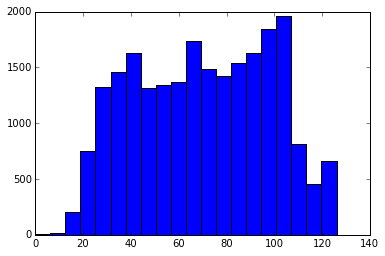

In [161]:
plt.hist(y_train, bins=20)

In [162]:
bins_extra = [np.percentile(y_train, 0),
        np.percentile(y_train, 25),
        np.percentile(y_train, 50),
        np.percentile(y_train, 75),
        np.percentile(y_train, 100) + 1]

In [163]:
bins_extra

[0.0, 46.0, 71.0, 94.0, 127.0]

In [164]:
y_train = np.digitize(y_train, bins_extra) - 1
y_val = np.digitize(y_val, bins_extra) - 1
y_test = np.digitize(y_test, bins_extra) - 1

(array([ 5612.,     0.,     0.,  5779.,     0.,     0.,  5556.,     0.,
            0.,  6025.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

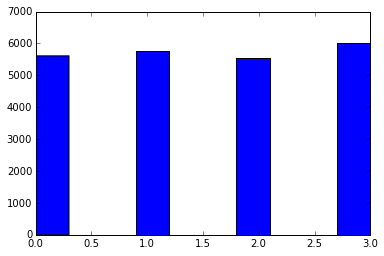

In [165]:
plt.hist(y_train)

In [ ]:
clf = LogisticRegression(C=0.01, penalty='l1')
clf.fit(f1_train, y_train).score(f1_val, y_val)

0.70199999999999996

In [ ]:
basic_wildfowl = Stacking(base_estimators=[
        (LogisticRegression(C=0.01, penalty='l1').fit,
         lambda clf, X: clf.predict(X)),
        (lambda X, y: LinearSVC(C=1, penalty='l2', loss='squared_hinge',
                                dual=True, multi_class='crammer_singer').fit(normalizer.transform(X), y),
         lambda clf, X: clf.predict(normalizer.transform(X))),
        (lambda X, y: LogisticRegression(C=8, penalty='l1').fit(normalizer.transform(X), y),
         lambda clf, X: clf.predict(normalizer.transform(X))),
        (lambda X, y: SVC(C=1, kernel='rbf', gamma=1).fit(normalizer.transform(X), y),
         lambda clf, X: clf.predict(normalizer.transform(X))),
        (lambda X, y: SVC(C=1, kernel='poly', gamma=1, degree=2).fit(normalizer.transform(X), y),
         lambda clf, X: clf.predict(normalizer.transform(X)))],
                    n_folds=5, extend_meta=False)
basic_wildfowl.fit(np.array(f1_train), y_train)

In [ ]:
basic_wildfowl.fit_meta(SVC(C=1, kernel='rbf', gamma=0.2).fit).score(np.array(f1_val), y_val)

In [ ]:
1

# Network deleted road, classes

In [37]:
with open('data_rem_road.pkl', 'rb') as f:
    X_train, Seg_train, y_train, X_val, Seg_val, y_val, X_test, Seg_test, y_test = pickle.load(f)
    
with open('features_rem_road.pkl', 'rb') as f:
    f1_train, f1_val, f1_test, f2_train, f2_val, f2_test = pickle.load(f)
    
bins = [np.percentile(y_train, 0),
        np.percentile(y_train, 25),
        np.percentile(y_train, 50),
        np.percentile(y_train, 75),
        np.percentile(y_train, 100) + 1]

y_train = np.digitize(y_train, bins) - 1
y_val = np.digitize(y_val, bins) - 1
y_test = np.digitize(y_test, bins) - 1

input_layer = InputLayer((None, f1_train[0].shape[0]))
ll1 = DenseLayer(input_layer, num_units=2048, nonlinearity=lasagne.nonlinearities.elu)
dr1 = DropoutLayer(ll1, p=0.5)
ll2 = DenseLayer(dr1, num_units=2048, nonlinearity=lasagne.nonlinearities.elu)
dr3 = DropoutLayer(ll2, p=0.5)
ll3 = DenseLayer(dr3, num_units=1024, nonlinearity=lasagne.nonlinearities.elu)
dr4 = DropoutLayer(ll3, p=0.5)
ll4 = DenseLayer(dr4, num_units=512, nonlinearity=lasagne.nonlinearities.elu)
dr5 = DropoutLayer(ll4, p=0.5)
ll5 = DenseLayer(dr5, num_units=256, nonlinearity=lasagne.nonlinearities.elu)
dr6 = DropoutLayer(ll5, p=0.5)
percentile = DenseLayer(dr6, num_units=len(set(y_train)), nonlinearity=softmax)

target_y = T.vector("target Y integer", dtype='int32')
input_X = T.matrix('X')

probs = lasagne.layers.get_output(percentile, input_X, deterministic = True)
y_predicted = np.argmax(probs, axis=1)

#all network weights (shared variables)
all_weights = lasagne.layers.get_all_params(percentile)
print(all_weights)

#Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(probs, target_y).mean()
l2_penalty = regularize_layer_params(percentile, l2) * 1e-1
l1_penalty = regularize_layer_params(percentile, l1) * 1e-3
loss += l2_penalty + l1_penalty

#prediction accuracy
accuracy = lasagne.objectives.categorical_accuracy(probs, target_y).mean()

#This function computes gradient AND composes weight updates just like you did earlier
updates_sgd = lasagne.updates.adagrad(loss, all_weights, learning_rate=0.01)

#function that computes loss and updates weights
train_fun = theano.function([input_X, target_y], [loss, accuracy], updates = updates_sgd)

#function that just computes accuracy
accuracy_fun = theano.function([input_X, target_y],accuracy)

num_epochs = 30 #amount of passes through the data

batch_size = 100 #number of samples processed at each function call

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(f1_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets.astype(np.int32))
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(f1_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets.astype(np.int32))
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

[W, b, W, b, W, b, W, b, W, b, W, b]
Epoch 1 of 30 took 1.998s
  training loss (in-iteration):		3749.619600
  train accuracy:		28.59 %
  validation accuracy:		26.00 %
Epoch 2 of 30 took 2.015s
  training loss (in-iteration):		3.113019
  train accuracy:		32.24 %
  validation accuracy:		46.60 %
Epoch 3 of 30 took 1.982s
  training loss (in-iteration):		2.176733
  train accuracy:		45.90 %
  validation accuracy:		49.40 %
Epoch 4 of 30 took 2.010s
  training loss (in-iteration):		1.896570
  train accuracy:		52.72 %
  validation accuracy:		58.00 %
Epoch 5 of 30 took 1.978s
  training loss (in-iteration):		1.765641
  train accuracy:		58.38 %
  validation accuracy:		52.20 %
Epoch 6 of 30 took 2.000s
  training loss (in-iteration):		1.671071
  train accuracy:		63.17 %
  validation accuracy:		62.00 %
Epoch 7 of 30 took 2.000s
  training loss (in-iteration):		1.551463
  train accuracy:		69.31 %
  validation accuracy:		55.20 %
Epoch 8 of 30 took 2.111s
  training loss (in-iteration):		1.477413
  t

KeyboardInterrupt: 

# Network with road, 5 classes

In [ ]:
with open('data_basic.pkl', 'rb') as f:
    X_train, Seg_train, y_train, X_val, Seg_val, y_val, X_test, Seg_test, y_test = pickle.load(f)
    
with open('features_basic.pkl', 'rb') as f:
    f1_train, f1_val, f1_test, f2_train, f2_val, f2_test = pickle.load(f)
    
bins = [np.percentile(y_train, 0),
        np.percentile(y_train, 25),
        np.percentile(y_train, 50),
        np.percentile(y_train, 75),
        np.percentile(y_train, 100) + 1]

y_train = np.digitize(y_train, bins) - 1
y_val = np.digitize(y_val, bins) - 1
y_test = np.digitize(y_test, bins) - 1

In [36]:
input_layer = InputLayer((None, f1_train[0].shape[0]))
ll1 = DenseLayer(input_layer, num_units=2048, nonlinearity=lasagne.nonlinearities.elu)
dr1 = DropoutLayer(ll1, p=0.5)
ll2 = DenseLayer(dr1, num_units=2048, nonlinearity=lasagne.nonlinearities.elu)
dr3 = DropoutLayer(ll2, p=0.5)
ll3 = DenseLayer(dr3, num_units=1024, nonlinearity=lasagne.nonlinearities.elu)
dr4 = DropoutLayer(ll3, p=0.5)
ll4 = DenseLayer(dr4, num_units=512, nonlinearity=lasagne.nonlinearities.elu)
dr5 = DropoutLayer(ll4, p=0.5)
ll5 = DenseLayer(dr5, num_units=256, nonlinearity=lasagne.nonlinearities.elu)
dr6 = DropoutLayer(ll5, p=0.5)
percentile = DenseLayer(dr6, num_units=len(set(y_train)), nonlinearity=softmax)

target_y = T.vector("target Y integer", dtype='int32')
input_X = T.matrix('X')

probs = lasagne.layers.get_output(percentile, input_X, deterministic = True)
y_predicted = np.argmax(probs, axis=1)

#all network weights (shared variables)
all_weights = lasagne.layers.get_all_params(percentile)
print(all_weights)

#Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(probs, target_y).mean()
l2_penalty = regularize_layer_params(percentile, l2) * 1e-1
l1_penalty = regularize_layer_params(percentile, l1) * 1e-2
loss += l2_penalty + l1_penalty

#prediction accuracy
accuracy = lasagne.objectives.categorical_accuracy(probs, target_y).mean()

#This function computes gradient AND composes weight updates just like you did earlier
updates_sgd = lasagne.updates.adagrad(loss, all_weights, learning_rate=0.005)

#function that computes loss and updates weights
train_fun = theano.function([input_X, target_y], [loss, accuracy], updates = updates_sgd)

#function that just computes accuracy
accuracy_fun = theano.function([input_X, target_y],accuracy)

num_epochs = 300 #amount of passes through the data

batch_size = 100 #number of samples processed at each function call

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(f1_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets.astype(np.int32))
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(f1_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets.astype(np.int32))
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

[W, b, W, b, W, b, W, b, W, b, W, b]
Epoch 1 of 300 took 2.036s
  training loss (in-iteration):		140.387504
  train accuracy:		31.28 %
  validation accuracy:		52.80 %
Epoch 2 of 300 took 2.016s
  training loss (in-iteration):		13.295092
  train accuracy:		55.17 %
  validation accuracy:		58.20 %
Epoch 3 of 300 took 2.002s
  training loss (in-iteration):		12.705572
  train accuracy:		62.45 %
  validation accuracy:		60.40 %
Epoch 4 of 300 took 2.003s
  training loss (in-iteration):		12.226186
  train accuracy:		68.86 %
  validation accuracy:		60.40 %
Epoch 5 of 300 took 2.002s
  training loss (in-iteration):		11.880651
  train accuracy:		71.07 %
  validation accuracy:		60.20 %
Epoch 6 of 300 took 2.014s
  training loss (in-iteration):		11.404465
  train accuracy:		79.07 %
  validation accuracy:		61.80 %
Epoch 7 of 300 took 2.018s
  training loss (in-iteration):		11.053822
  train accuracy:		84.86 %
  validation accuracy:		65.00 %
Epoch 8 of 300 took 1.896s
  training loss (in-iteration):	

KeyboardInterrupt: 

# Network deleted road, 5 classes, stacked with segs

In [9]:
with open('data_rem_road.pkl', 'rb') as f:
    X_train, Seg_train, y_train, X_val, Seg_val, y_val, X_test, Seg_test, y_test = pickle.load(f)
    
with open('features_rem_road.pkl', 'rb') as f:
    f1_train, f1_val, f1_test, f2_train, f2_val, f2_test = pickle.load(f)
    
f1_train = np.hstack((np.array(f1_train), np.array(f2_train)))
f1_val = np.hstack((np.array(f1_val), np.array(f2_val)))
    
bins = [np.percentile(y_train, 0),
        np.percentile(y_train, 25),
        np.percentile(y_train, 50),
        np.percentile(y_train, 75),
        np.percentile(y_train, 100) + 1]

y_train = np.digitize(y_train, bins) - 1
y_val = np.digitize(y_val, bins) - 1
y_test = np.digitize(y_test, bins) - 1

input_layer = InputLayer((None, f1_train[0].shape[0]))
ll1 = DenseLayer(input_layer, num_units=4096)
dr1 = DropoutLayer(ll1, p=0.5)
ll2 = DenseLayer(dr1, num_units=4096)
dr3 = DropoutLayer(ll2, p=0.5)
percentile = DenseLayer(dr3, num_units=len(set(y_train)), nonlinearity=softmax)

target_y = T.vector("target Y integer", dtype='int32')
input_X = T.matrix('X')

probs = lasagne.layers.get_output(percentile, input_X, deterministic = True)
y_predicted = np.argmax(probs, axis=1)

#all network weights (shared variables)
all_weights = lasagne.layers.get_all_params(percentile)
print(all_weights)

#Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(probs, target_y).mean()
l2_penalty = regularize_layer_params(percentile, l2) * 1e-2
l1_penalty = regularize_layer_params(percentile, l1) * 1e-3
loss += l2_penalty + l1_penalty

#prediction accuracy
accuracy = lasagne.objectives.categorical_accuracy(probs, target_y).mean()

#This function computes gradient AND composes weight updates just like you did earlier
updates_sgd = lasagne.updates.adagrad(loss, all_weights, learning_rate=0.01)

#function that computes loss and updates weights
train_fun = theano.function([input_X, target_y], [loss, accuracy], updates = updates_sgd)

#function that just computes accuracy
accuracy_fun = theano.function([input_X, target_y],accuracy)

num_epochs = 30 #amount of passes through the data

batch_size = 100 #number of samples processed at each function call

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(f1_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets.astype(np.int32))
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(f1_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets.astype(np.int32))
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

[W, b, W, b, W, b]


MemoryError: Error allocating 603979776 bytes of device memory (out of memory).
Apply node that caused the error: GpuDot22(GpuDimShuffle{1,0}.0, GpuElemwise{Composite{(i0 + (i0 * sgn(i1)))}}[(0, 0)].0)
Toposort index: 54
Inputs types: [CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix)]
Inputs shapes: [(36864, 100), (100, 4096)]
Inputs strides: [(1, 36864), (4096, 1)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[GpuElemwise{Sqr}[(0, 0)](GpuDot22.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

# Network with road, 5 classes, stacked with segs

In [8]:
with open('data_basic.pkl', 'rb') as f:
    X_train, Seg_train, y_train, X_val, Seg_val, y_val, X_test, Seg_test, y_test = pickle.load(f)
    
with open('features_basic.pkl', 'rb') as f:
    f1_train, f1_val, f1_test, f2_train, f2_val, f2_test = pickle.load(f)
    
f1_train = np.hstack((np.array(f1_train), np.array(f2_train)))
f1_val = np.hstack((np.array(f1_val), np.array(f2_val)))
    
bins = [np.percentile(y_train, 0),
        np.percentile(y_train, 25),
        np.percentile(y_train, 50),
        np.percentile(y_train, 75),
        np.percentile(y_train, 100) + 1]

y_train = np.digitize(y_train, bins) - 1
y_val = np.digitize(y_val, bins) - 1
y_test = np.digitize(y_test, bins) - 1

input_layer = InputLayer((None, f1_train[0].shape[0]))
ll1 = DenseLayer(input_layer, num_units=4096)
dr1 = DropoutLayer(ll1, p=0.5)
ll2 = DenseLayer(dr1, num_units=4096)
dr3 = DropoutLayer(ll2, p=0.5)
percentile = DenseLayer(dr3, num_units=len(set(y_train)), nonlinearity=softmax)

target_y = T.vector("target Y integer", dtype='int32')
input_X = T.matrix('X')

probs = lasagne.layers.get_output(percentile, input_X, deterministic = True)
y_predicted = np.argmax(probs, axis=1)

#all network weights (shared variables)
all_weights = lasagne.layers.get_all_params(percentile)
print(all_weights)

#Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(probs, target_y).mean()
l2_penalty = regularize_layer_params(percentile, l2) * 1e-1
l1_penalty = regularize_layer_params(percentile, l1) * 1e-2
loss += l2_penalty + l1_penalty

#prediction accuracy
accuracy = lasagne.objectives.categorical_accuracy(probs, target_y).mean()

#This function computes gradient AND composes weight updates just like you did earlier
updates_sgd = lasagne.updates.adagrad(loss, all_weights, learning_rate=0.01)

#function that computes loss and updates weights
train_fun = theano.function([input_X, target_y], [loss, accuracy], updates = updates_sgd)

#function that just computes accuracy
accuracy_fun = theano.function([input_X, target_y],accuracy)

num_epochs = 30 #amount of passes through the data

batch_size = 100 #number of samples processed at each function call

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(f1_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets.astype(np.int32))
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(f1_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets.astype(np.int32))
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

[W, b, W, b, W, b]
Epoch 1 of 30 took 4.315s
  training loss (in-iteration):		4726.092065
  train accuracy:		24.38 %
  validation accuracy:		33.00 %
Epoch 2 of 30 took 4.367s
  training loss (in-iteration):		11.885494
  train accuracy:		30.03 %
  validation accuracy:		26.00 %
Epoch 3 of 30 took 4.157s
  training loss (in-iteration):		5.118199
  train accuracy:		30.03 %
  validation accuracy:		25.20 %
Epoch 4 of 30 took 4.156s
  training loss (in-iteration):		4.719048
  train accuracy:		33.24 %
  validation accuracy:		25.00 %
Epoch 5 of 30 took 4.154s
  training loss (in-iteration):		4.602650
  train accuracy:		33.83 %
  validation accuracy:		25.40 %
Epoch 6 of 30 took 4.158s
  training loss (in-iteration):		4.511264
  train accuracy:		34.45 %
  validation accuracy:		29.20 %
Epoch 7 of 30 took 4.156s
  training loss (in-iteration):		4.433514
  train accuracy:		35.31 %
  validation accuracy:		31.80 %
Epoch 8 of 30 took 4.153s
  training loss (in-iteration):		4.364174
  train accuracy:		3

## ANN

We tried the structure that follows the structure of VGG19. The difference was to add elu nonlinearities to all the dense layers.
The structure is the following:

DenseLayer - 2048 units + elu

DropoutLayer - 50%

DenseLayer - 2048 units + elu

DropoutLayer - 50%

DenseLayer - 1024 units + elu

DropoutLayer - 50%

DenseLayer - 512 units + elu

DropoutLayer - 50%

DenseLayer - 256 units + elu

DropoutLayer - 50%

DenseLayer - Softmax

First we tried to add these layers to output of VGG19 features leayers. The problem was that it required much higher amount of memory and we couldn't use batches even of size 50.
Next we used the described network as a separate classifier. It allowed us to use much higher batch sizes. 

Furthermore we faced the problem of overfitting. In order to deal with that we introduced l2 ans l1 regularizations to the loss.

Talking about loss it is impotrant to mention that we decided to use categorical_crossentropy as a loss function. It was motivated by the fact that we dealed with different sizes of classes (we started with binary classification problem and went to 4 classes classification).

We had to play with regularization weights. Increasing and decreasing it we could limit overfiting and imrpove the loss on validation set.

## Linear models

MK

# Conclusion

All